In [41]:
# Initial Set-Up
import numpy as np
import pandas as pd
import requests
import psycopg2
import matplotlib.pyplot as plt
import json
import seaborn as sns
import api_keys
from api_keys import FBI_api_key
import passwords
from passwords import password

ImportError: cannot import name 'password' from 'passwords' (C:\Users\jmortensen\Documents\CGDS\ETL_Project\passwords.py)

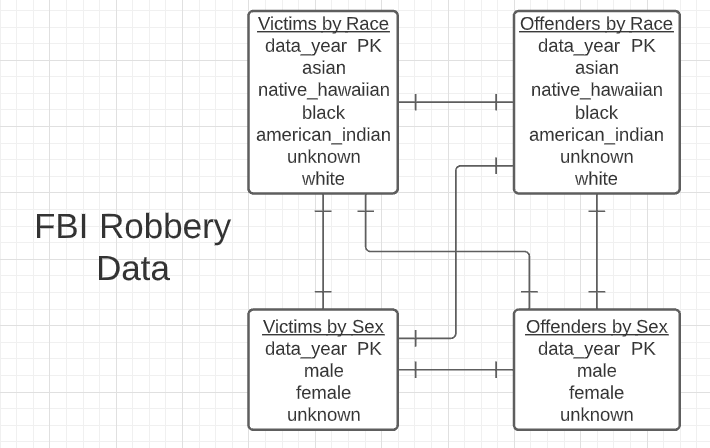

In [35]:
# Offender Data by Race
base_url_1 = "https://api.usa.gov/crime/fbi/sapi/api/data/nibrs/robbery/offender/national/race/?limit=1&api_key="
response1=requests.get(base_url_1+FBI_api_key)
r_offender_data=json.loads(response1.text)
r_offender_data_df=pd.DataFrame(r_offender_data["results"])


# Add 'offenders' to column headings in anticipation of future joins
new_cols=[]
for i in range(len(r_offender_data_df.columns)-1):
    string = r_offender_data_df.columns[i]+'_offenders'
    new_cols.append(string)
new_cols.append('data_year')
r_offender_data_df.columns = new_cols

r_offender_data_df.head()

,asian offenders,native_hawaiian offenders,black offenders,american_indian offenders,unknown offenders,white offenders,data_year
0,50,0,10787,37,954,3760,1996
1,144,0,30200,82,3560,11462,2000
2,400,0,83646,284,7246,27467,2007
3,467,0,73183,497,8000,27320,2012
4,580,0,61809,618,8932,29068,2017


In [37]:
# Offender Data by Sex
base_url_2 = "https://api.usa.gov/crime/fbi/sapi/api/data/nibrs/robbery/offender/national/sex/?limit=1&api_key="
response2=requests.get(base_url_2+FBI_api_key)
s_offender_data=json.loads(response2.text)
s_offender_data_df=pd.DataFrame(s_offender_data["results"])


# Add 'offenders' to column headings in anticipation of future joins
new_cols=[]
for i in range(len(s_offender_data_df.columns)-1):
    string = s_offender_data_df.columns[i]+'_offenders'
    new_cols.append(string)
new_cols.append('data_year')
s_offender_data_df.columns = new_cols

s_offender_data_df.head()

,male_count offenders,female_count offenders,unknown offenders,data_year
0,14004,1002,582,1996
1,39855,2990,2603,2000
2,106207,8783,4053,2007
3,94975,9579,4913,2012
4,84404,11426,5223,2017


In [38]:
# Victim Data by Race
base_url_3 = "https://api.usa.gov/crime/fbi/sapi/api/data/nibrs/robbery/victim/national/race/?limit=1&api_key="
response3=requests.get(base_url_3+FBI_api_key)
r_victim_data=json.loads(response3.text)
r_victim_data_df=pd.DataFrame(r_victim_data["results"])
r_victim_data_df.head()

# Add 'victims' to column headings in anticipation of future joins
new_cols=[]
for i in range(len(r_victim_data_df.columns)-1):
    string = r_victim_data_df.columns[i]+'_victims'
    new_cols.append(string)
new_cols.append('data_year')
r_victim_data_df.columns = new_cols

r_victim_data_df.head()

,asian victims,native_hawaiian victims,black victims,american_indian victims,unknown victims,white victims,data_year
0,132,0,4236,18,315,7843,1996
1,629,0,12196,120,1078,22467,2000
2,2194,0,30172,398,2281,49318,2012
3,2449,0,26227,667,2681,49487,2017
4,2,0,134,1,9,172,2005


In [39]:
# Victim Data by Sex
base_url_4 = "https://api.usa.gov/crime/fbi/sapi/api/data/nibrs/robbery/victim/national/sex/?limit=1&api_key="
response4=requests.get(base_url_4+FBI_api_key)
s_victim_data=json.loads(response4.text)
s_victim_data_df=pd.DataFrame(s_victim_data["results"])
s_victim_data_df.head()

# Add 'victims' to column headings in anticipation of future joins
new_cols=[]
for i in range(len(s_victim_data_df.columns)-1):
    string = s_victim_data_df.columns[i]+'_victims'
    new_cols.append(string)
new_cols.append('data_year')
s_victim_data_df.columns = new_cols

s_victim_data_df.head()

,male_count victims,female_count victims,unknown victims,data_year
0,8342,4166,36,1996
1,24249,12031,210,2000
2,55596,28577,190,2012
3,53024,28335,234,2017
4,213,102,3,2005


In [ ]:
CREATE DATABASE crime_data;

# Create tables 
CREATE TABLE obr(
    data_year integer PRIMARY KEY,
    asian_offenders integer,
    native_hawaiian_offenders integer,
    black_offenders integer,
    american_indian offenders integer,
    unknown offenders integer,
    white offenders integer


In [ ]:
# Connect to Postgres
conn = psycopg2.connect("host=localhost, dbname=crime_data, user=postgres, password = password")

# Create cursor object
cur = conn.cursor()

cur.execute()